
Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Version 0.4-0 included new data defaults. See ?getSymbols.
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.2.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date()        masks base::date()
✖ dplyr::filter()          masks stats::filter()
✖ dplyr::first()           masks xts::first()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ dplyr::last()        

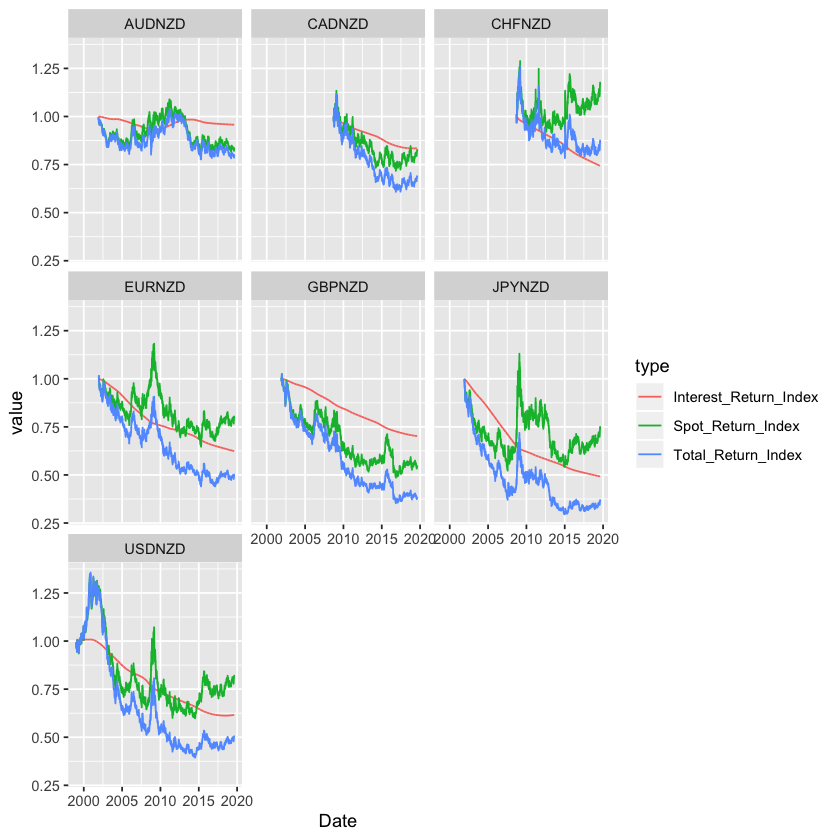

In [1]:
# load data

DATA_FOLDER <- '~/Resilio\ Sync/FXBootcamp'

## Get Hourly Exchange Rate Data
source(paste0('data-utils.R'))
tickers <- c('NZD/USD','AUD/NZD','EUR/NZD','GBP/NZD','NZD/CAD','NZD/CHF','NZD/JPY')
raw_prices_df <- get_daily_OHLC(tickers)

# Adjust to common quote currency and calulate total returns
nzd_prices_df <- convert_common_quote_currency(raw_prices_df, quote_currency = 'NZD')

# Append interest rates
currencies <- get_unique_currencies(nzd_prices_df)
policy_rates_df <- get_policy_rates(currencies)
nzd_extended_prices_df <- append_interest_rate_differential(nzd_prices_df, policy_rates_df)

# Calculate returns
returns_df <-  nzd_extended_prices_df %>%
  group_by(Ticker) %>%
  tq_transmute_(select = "Total_Return_Index", mutate_fun = 'periodReturn', period = 'monthly', col_rename = 'returns')

# plot
nzd_extended_prices_df %>%
  group_by(Ticker) %>%
  select(Ticker, Date, Spot_Return_Index, Interest_Return_Index, Total_Return_Index) %>%
  gather('Spot_Return_Index','Interest_Return_Index','Total_Return_Index', key = 'type', value = 'value') %>%
  ggplot(aes(x = Date, y = value, colour = type)) +
  geom_line() +
  facet_wrap(~Ticker)

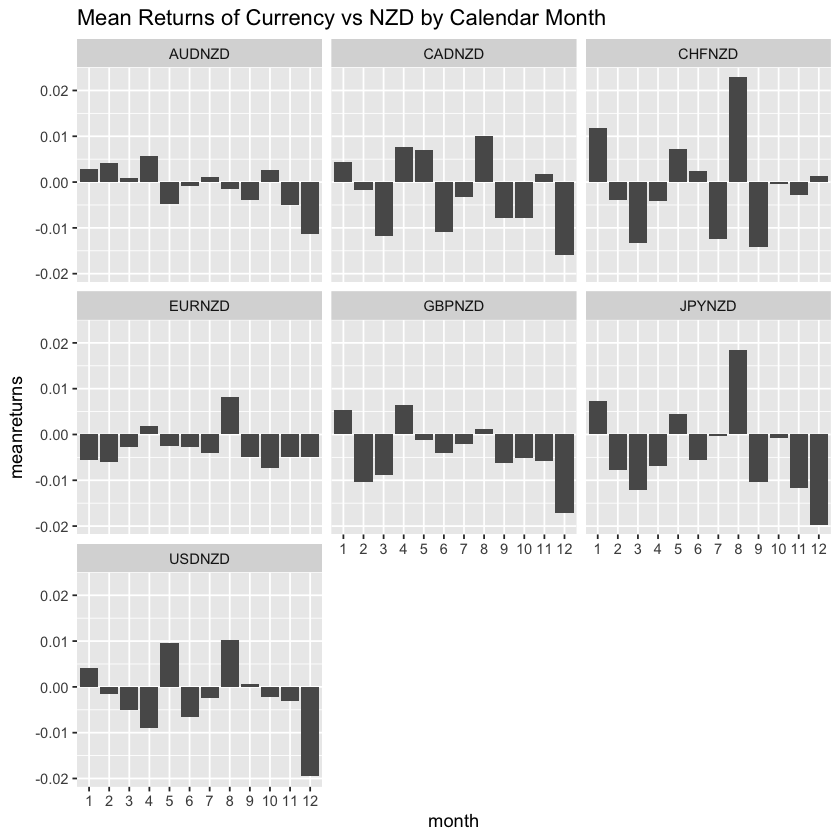

In [2]:
# Use timetk library to explode out date into components
library(timetk)
season_returns <- tk_augment_timeseries_signature(returns_df) 

# Group by month and plot mean returns
monthreturns <- season_returns %>%
  group_by(Ticker, month) %>%
  summarise(meanreturns = mean(returns))

# plot
monthreturns %>%
  mutate(month = as.factor(month)) %>%
  group_by(Ticker) %>%
  ggplot(aes(x=month, y=meanreturns)) +
  geom_bar(stat='identity') +
  labs(title = 'Mean Returns of Currency vs NZD by Calendar Month') +
  facet_wrap(~Ticker)

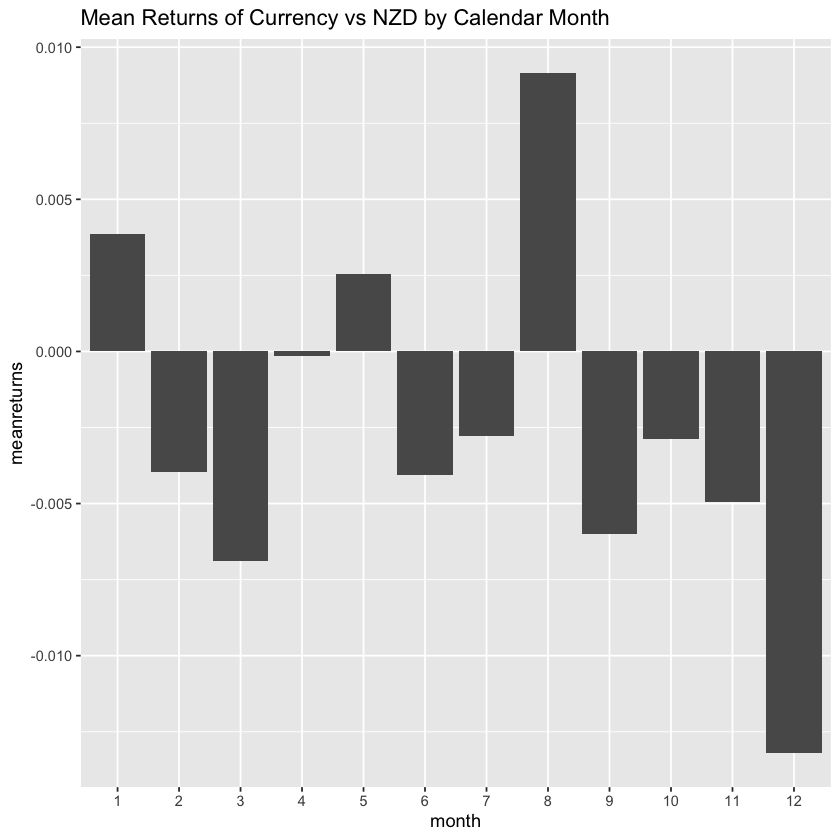

In [3]:
# mean returns by month, across all currencies
season_returns %>%
  group_by(month) %>%
  summarise(meanreturns = mean(returns)) %>%
  mutate(month = as.factor(month)) %>%
  ggplot(aes(x=month, y=meanreturns)) +
  geom_bar(stat='identity') +
  labs(title = 'Mean Returns of Currency vs NZD by Calendar Month')

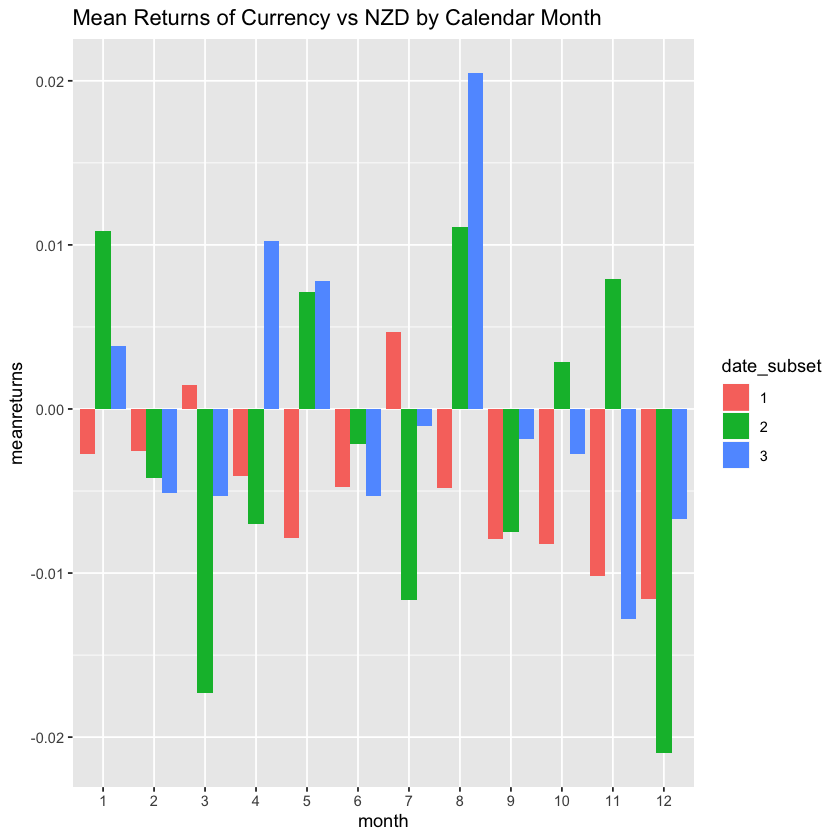

In [4]:
# subset data and plot
season_returns %>%
  mutate(date_subset = as.factor(ntile(Date, 3))) %>%
  mutate(month = as.factor(month)) %>%
  group_by(date_subset, month) %>%
  summarise(meanreturns = mean(returns)) %>%
  ggplot(aes(x=month, y=meanreturns, fill=date_subset)) +
  geom_bar(stat='identity', position = 'dodge') +
  labs(title = 'Mean Returns of Currency vs NZD by Calendar Month')